Tiền xử lý dữ 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Khởi chạy dữ liệu 
df = pd.read_csv('D:\\HKI Năm 3\\Machine Learning\\finalMLProject\\data\\framingham (1).csv')
df = df.drop(columns='education')
# df.head()
print("Thông tin về các trường, kiểu dữ liệu:")
df.info()  
print(f'Thống kê sơ bộ về các trường số:\n {df.describe()}') 
print(f' Hiển thị 5 bản ghi đầu tiên:\n {df.head()}') 

Thông tin về các trường, kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4211 non-null   float64
 4   BPMeds           4187 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4190 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4221 non-null   float64
 12  heartRate        4239 non-null   float64
 13  glucose          3852 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB
Thống kê sơ bộ về cá

In [22]:
#Kiểm tra giá trị rỗng 
df.isnull().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [23]:
df.shape

(4240, 15)

In [24]:
# Định nghĩa các cột nhị phân
bin_cols = ["male", "currentSmoker", "prevalentStroke", "prevalentHyp", "diabetes"]

# Điền các giá trị còn thiếu cho các tính năng nhị phân có giá trị thường xuyên nhất (mode)
for col in bin_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val) 

# Kiểm tra xem có bất kỳ giá trị nào còn thiếu không
missing_values = df.isnull().sum()

In [25]:
df['TenYearCHD'].value_counts()

TenYearCHD
0    3596
1     644
Name: count, dtype: int64

In [26]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['TenYearCHD'] == 0]
df_minority = df[df['TenYearCHD'] == 1]

# Lớp thiểu số nâng cao
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),    # To match majority class
                                 random_state=42) # Reproducible results

# Kết hợp lớp đa số với lớp thiểu số được lấy mẫu lại
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [27]:
df_balanced['TenYearCHD'].value_counts()

TenYearCHD
0    3596
1    3596
Name: count, dtype: int64

# Biểu đồ thể hiện sự cân bằng dữ liệu

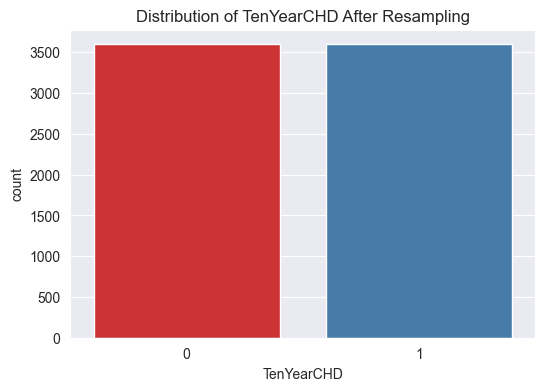

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TenYearCHD', data=df_balanced, hue='TenYearCHD', palette='Set1', legend=False)
plt.title('Distribution of TenYearCHD After Resampling')
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Chia dữ liệu thành các tập huấn luyện và thử nghiệm
X = df_balanced.drop(columns=['TenYearCHD'])
y = df_balanced['TenYearCHD']

# Kiểm tra lại NaN
missing_values = df_balanced.isnull().sum()
print(missing_values[missing_values > 0])

# Áp dụng SimpleImputer để điền giá trị NaN còn lại
imputer = SimpleImputer(strategy='median')  # Điền giá trị median cho các cột số
X = imputer.fit_transform(X)

# Chia dữ liệu thành các tập huấn luyện và thử nghiệm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cigsPerDay     38
BPMeds        124
totChol        76
BMI            54
heartRate       9
glucose       590
dtype: int64


# Chuẩn hóa dữ liệu

In [10]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa dữ liệu 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.fit_transform(X)

# Mô hình

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Xác định danh sách các bộ phân loại
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    GaussianNB(),
]

# Tạo một từ điển để lưu trữ kết quả
results = {}

In [12]:
# 1. Huấn luyện và đánh giá trên dữ liệu không giảm chiều
print("Độ chính xác trên dữ liệu không giảm chiều:")
for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = {"original_accuracy": accuracy}
    print(f"{clf_name} Accuracy (Original): {accuracy}")

Độ chính xác trên dữ liệu không giảm chiều:
LogisticRegression Accuracy (Original): 0.6617238183503243
KNeighborsClassifier Accuracy (Original): 0.7752548656163114
GaussianNB Accuracy (Original): 0.5894346617238183


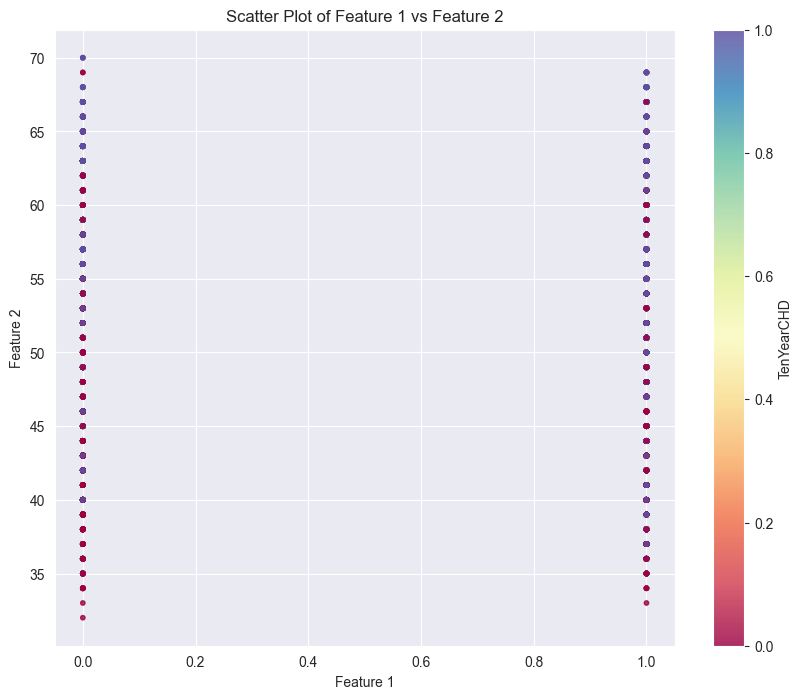

In [62]:
# Chuyển đổi X_train thành DataFrame và đặt tên cột
X_train_df = pd.DataFrame(X_train, columns=[f"Feature_{i+1}" for i in range(X_train.shape[1])])

# Trực quan hóa một vài cặp biến đặc trưng, ví dụ giữa đặc trưng đầu tiên và thứ hai
plt.figure(figsize=(10, 8))
plt.scatter(X_train_df.iloc[:, 0], X_train_df.iloc[:, 1], c=y_train, cmap='Spectral', s=10, alpha=0.8)
plt.colorbar(label='TenYearCHD')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Feature 1 vs Feature 2')
plt.show()

In [52]:
# 2. Giảm chiều dữ liệu xuống 2D bằng PCA
from sklearn.decomposition import PCA
import time

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) 

print("\tĐộ chính xác trên dữ liệu đã giảm chiều (PCA):")
# Huấn luyện và đánh giá trên dữ liệu đã giảm chiều bằng pca
for clf in classifiers:
    start_time = time.time()
    clf_name = clf.__class__.__name__
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    end_time = time.time()
    
    time_result = end_time - start_time

    # Tính toán độ chính xác
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    results[clf_name]["pca_accuracy"] = accuracy_pca
    print(f"{clf_name} Accuracy (PCA): {accuracy_pca}")
    print(f"Time {clf_name} (PCA): {time_result}")

	Độ chính xác trên dữ liệu đã giảm chiều (PCA):
LogisticRegression Accuracy (PCA): 0.6251158480074143
Time LogisticRegression (PCA): 0.015622854232788086
KNeighborsClassifier Accuracy (PCA): 0.7701575532900834
Time KNeighborsClassifier (PCA): 0.09969401359558105
GaussianNB Accuracy (PCA): 0.6204819277108434
Time GaussianNB (PCA): 0.0


*****Dữ liệu sau khi giảm chiều bằng PCA*****

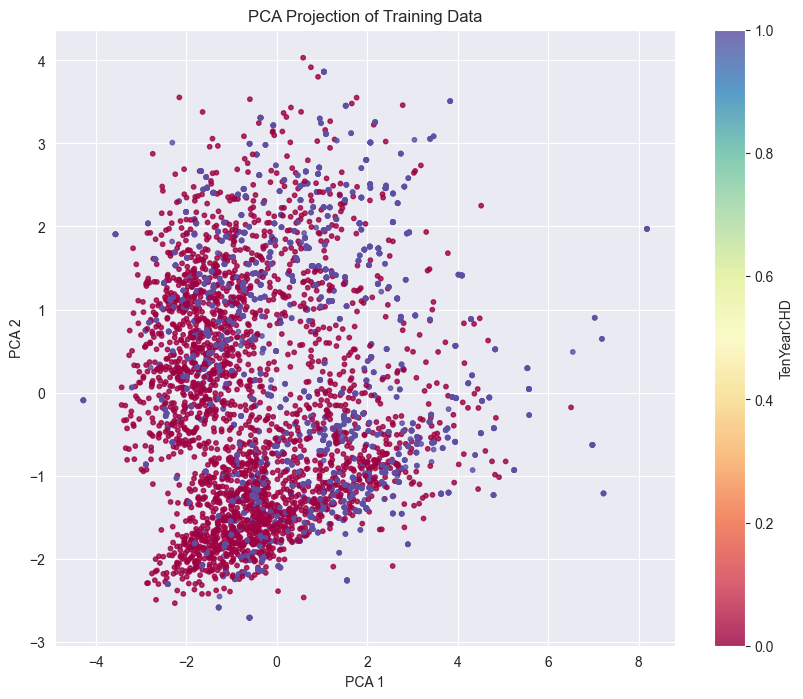

In [53]:
# Trực quan hóa dữ liệu sau khi giảm chiều bằng PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='Spectral', s=10, alpha=0.8)
plt.colorbar(label='TenYearCHD')
plt.title('PCA Projection of Training Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [54]:
# 3. Huấn luyện và đánh giá trên dữ liệu đã giảm chiều u-map
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_scaled)
X_test_umap = umap_model.transform(X_test_scaled)

print("\nĐộ chính xác trên dữ liệu đã giảm chiều (UMAP):")
# Huấn luyện và đánh giá trên dữ liệu đã giảm chiều bằng UMAP
for clf in classifiers:
    start_time = time.time()
    clf_name = clf.__class__.__name__
    clf.fit(X_train_umap, y_train)
    y_pred_umap = clf.predict(X_test_umap)
    end_time = time.time()
    
    time_result = end_time - start_time
# Tính toán độ chính xác
    accuracy_umap = accuracy_score(y_test, y_pred_umap)
    results[clf_name]["umap_accuracy"] = accuracy_umap
    print(f"{clf_name} Accuracy (UMAP): {accuracy_umap}")
    print(f"Time {clf_name} (UMAP): {time_result}")


Độ chính xác trên dữ liệu đã giảm chiều (UMAP):
LogisticRegression Accuracy (UMAP): 0.58758109360519
Time LogisticRegression (UMAP): 0.015623807907104492
KNeighborsClassifier Accuracy (UMAP): 0.7344763670064874
Time KNeighborsClassifier (UMAP): 0.0781393051147461
GaussianNB Accuracy (UMAP): 0.5991658943466173
Time GaussianNB (UMAP): 0.0


******Dữ liệu trực quan hóa sau khi giảm chiều bằng UMAP******

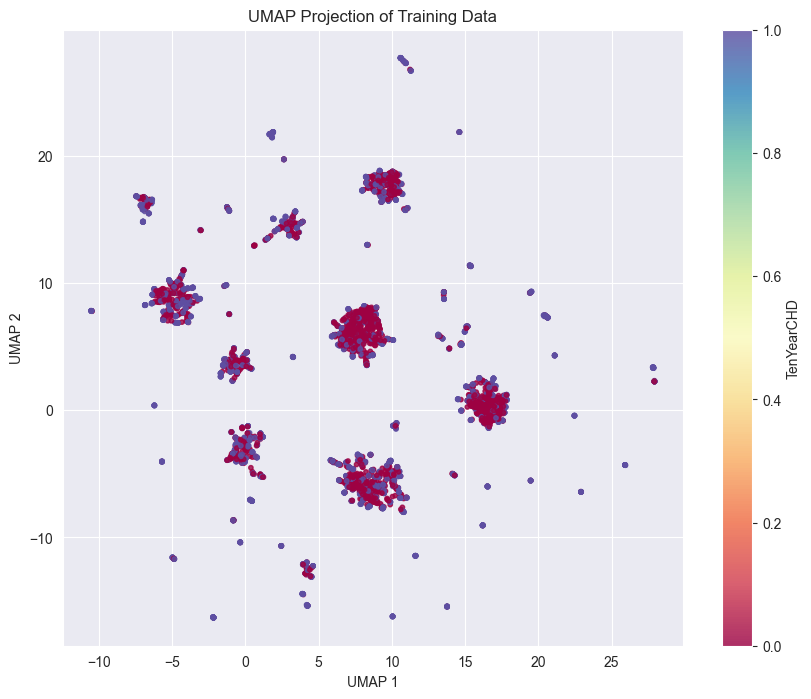

In [55]:
# Trực quan hóa dữ liệu huấn luyện đã giảm chiều bằng UMAP
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Spectral', s=10, alpha=0.8)
plt.colorbar(label='TenYearCHD')  # Nhãn mục tiêu (target)
plt.title('UMAP Projection of Training Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [56]:
# 5. Hiển thị kết quả so sánh 
print("\nSo sánh độ chính xác giữa dữ liệu không giảm chiều và giảm chiều:")
for clf_name, accuracies in results.items():
    print(f"{clf_name}:")
    print(f"  Original Accuracy: {accuracies['original_accuracy']}")
    print(f"  PCA Accuracy: {accuracies['pca_accuracy']}")
    print("="*50)


So sánh độ chính xác giữa dữ liệu không giảm chiều và giảm chiều:
LogisticRegression:
  Original Accuracy: 0.6617238183503243
  PCA Accuracy: 0.6251158480074143
KNeighborsClassifier:
  Original Accuracy: 0.7752548656163114
  PCA Accuracy: 0.7701575532900834
GaussianNB:
  Original Accuracy: 0.5894346617238183
  PCA Accuracy: 0.6204819277108434


*****PHÂN CỤM*****

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 1. Phân cụm bằng K-Means trên dữ liệu gốc
kmeans_original = KMeans(n_clusters=2, random_state=42)
kmeans_original.fit(X_train_scaled)
original_cluster_labels = kmeans_original.predict(X_test_scaled)

# Tính ARI và Silhouette Score trên dữ liệu gốc
ari_original = adjusted_rand_score(y_test, original_cluster_labels)
silhouette_original = silhouette_score(X_test_scaled, original_cluster_labels)

# In kết quả so sánh
print("Kết quả phân cụm K-Means trên dữ liệu gốc (chưa giảm chiều):")
print(f"  Adjusted Rand Index (ARI): {ari_original}")
print(f"  Silhouette Score: {silhouette_original}\n")

Kết quả phân cụm K-Means trên dữ liệu gốc (chưa giảm chiều):
  Adjusted Rand Index (ARI): 0.03889467149733471
  Silhouette Score: 0.20521116983318372



In [70]:
# 2. Giảm chiều dữ liệu bằng PCA rồi phân cụm
pca_model = PCA(n_components=2)
X_train_pca = pca_model.fit_transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit(X_train_pca)
pca_cluster_labels = kmeans_pca.predict(X_test_pca)

# Tính ARI và Silhouette Score trên dữ liệu PCA
ari_pca = adjusted_rand_score(y_test, pca_cluster_labels)
silhouette_pca = silhouette_score(X_test_pca, pca_cluster_labels)

# In kết quả so sánh
print("Kết quả phân cụm K-Means sau khi giảm chiều bằng PCA:")
print(f"  Adjusted Rand Index (ARI): {ari_pca}")
print(f"  Silhouette Score: {silhouette_pca}\n")

Kết quả phân cụm K-Means sau khi giảm chiều bằng PCA:
  Adjusted Rand Index (ARI): 0.033477984891586036
  Silhouette Score: 0.40113222493982587



In [71]:
# 3. Giảm chiều dữ liệu bằng UMAP rồi phân cụm
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_scaled)
X_test_umap = umap_model.transform(X_test_scaled)

kmeans_umap = KMeans(n_clusters=3 , random_state=42)
clusters_umap = kmeans_umap.fit(X_train_umap)
umap_cluster_labels = kmeans_umap.predict(X_test_umap)

# Tính ARI và Silhouette Score trên dữ liệu UMAP
ari_umap = adjusted_rand_score(y_test, umap_cluster_labels)
silhouette_umap = silhouette_score(X_test_umap, umap_cluster_labels)

# In kết quả so sánh
print("Kết quả phân cụm K-Means sau khi giảm chiều bằng UMAP:")
print(f"  Adjusted Rand Index (ARI): {ari_umap}")
print(f"  Silhouette Score: {silhouette_umap}")


Kết quả phân cụm K-Means sau khi giảm chiều bằng UMAP:
  Adjusted Rand Index (ARI): 0.011489780421651826
  Silhouette Score: 0.4436804950237274
